In [38]:
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential, Model
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Activation, Input, Permute, Flatten, multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import tensorflow as tf
from sklearn.metrics import classification_report, f1_score
import pandas as pd
import seaborn as sns

### Import data

In [2]:
X = []
y = []

file_url = 'data/comment.txt'

with open(file_url, 'r', encoding='utf-8') as fo:
    for line in fo:
        row = line.split(' ', 1)
        X.append(row[1].strip())
        y.append(row[0])
        
y = [1 if _=='v1' else 0 for _ in y]

### Preprocess data

In [3]:
MAXLEN = 50

tokenizer = Tokenizer(oov_token='<UNK>', char_level=True)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_seq = pad_sequences(X_seq, maxlen=MAXLEN, padding='post', value=0)

### Split data into train and test

In [4]:
np.random.seed(1)
index = list(range(len(X)))
np.random.shuffle(index)

# set training length as 95%
TRAINLEN = round(len(X)*0.95)
train_index = index[:TRAINLEN]
val_index = index[TRAINLEN:]


x_train_raw = [X[i] for i in train_index]
x_val_raw = [X[i] for i in val_index]

x_train = [X_seq[i] for i in train_index]
y_train = [y[i] for i in train_index]
x_val = [X_seq[i] for i in val_index]
y_val = [y[i] for i in val_index]

### RNN

In [47]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBED_DIM = 40
RNN_UNITS = 60

model_rnn = Sequential()
model_rnn.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAXLEN, name='embedding'))
model_rnn.add(SimpleRNN(RNN_UNITS, activation='tanh', name='rnn'))
model_rnn.add(Dense(1, activation='sigmoid', name='sigmoid'))

model_rnn.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.summary()

print('Input and output shapes: \n')
for layer in model_rnn.layers:
    print('{}-- input shape: {} output shape {}'.format(layer.name, layer.input_shape, layer.output_shape))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 40)            179440    
_________________________________________________________________
rnn (SimpleRNN)              (None, 60)                6060      
_________________________________________________________________
sigmoid (Dense)              (None, 1)                 61        
Total params: 185,561
Trainable params: 185,561
Non-trainable params: 0
_________________________________________________________________
Input and output shapes: 

embedding-- input shape: (None, 50) output shape (None, 50, 40)
rnn-- input shape: (None, 50, 40) output shape (None, 60)
sigmoid-- input shape: (None, 60) output shape (None, 1)


In [34]:
BATCH_SIZE = 64
EPOCHS = 8

earlystopping = EarlyStopping(monitor='val_loss',verbose=1, patience=2,mode='min')
checkpoint = ModelCheckpoint('model/model_rnn1.h5',monitor='val_loss',verbose=1, save_best_only=True, mode='min')

model_rnn.fit(np.array(x_train), np.array(y_train),
              batch_size=BATCH_SIZE, 
              epochs=EPOCHS, 
              validation_split=0.1,
              callbacks=[earlystopping, checkpoint])

Train on 161713 samples, validate on 17969 samples
Epoch 1/8
161713/161713 [==============================] - 44s 273us/step - loss: 0.3590 - val_loss: 0.3507

Epoch 00001: val_loss improved from inf to 0.35065, saving model to model/model_rnn1.h5
Epoch 2/8
161713/161713 [==============================] - 49s 301us/step - loss: 0.2979 - val_loss: 0.3064

Epoch 00002: val_loss improved from 0.35065 to 0.30644, saving model to model/model_rnn1.h5
Epoch 3/8
161713/161713 [==============================] - 48s 298us/step - loss: 0.2752 - val_loss: 0.2969: 3s  -

Epoch 00003: val_loss improved from 0.30644 to 0.29689, saving model to model/model_rnn1.h5
Epoch 4/8
161713/161713 [==============================] - 49s 302us/step - loss: 0.2565 - val_loss: 0.2841

Epoch 00004: val_loss improved from 0.29689 to 0.28408, saving model to model/model_rnn1.h5
Epoch 5/8
161713/161713 [==============================] - 48s 298us/step - loss: 0.2443 - val_loss: 0.2737

Epoch 00005: val_loss improved fr

In [53]:
model = load_model('model/model_rnn1.h5')

pred = model.predict(np.array(x_val))
pred = [1 if x[0]>.5 else 0 for x in pred]
report = classification_report(y_true=np.array(y_val), y_pred=pred, target_names=['neg','pos'])
print(report)

f1_macro = f1_score(y_val, pred, average='macro')
print('F1 score (macro): {}'.format(f1_macro))

             precision    recall  f1-score   support

        neg       0.87      0.88      0.87      3857
        pos       0.92      0.91      0.91      5600

avg / total       0.90      0.90      0.90      9457

F1 score (macro): 0.8936140955094104


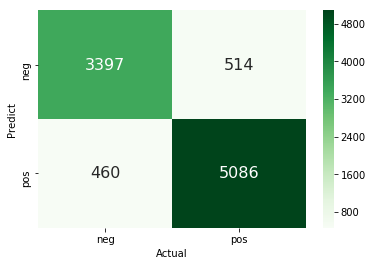

In [55]:
LABELS = {0:'neg',1:'pos'}

df = pd.DataFrame(data={'Predict':pred,
                       'Actual': y_val})
df_cm = df.groupby(['Predict','Actual']).count().reset_index()
df_cm['Predict'] = df_cm['Predict'].map(LABELS)
df_cm['Actual'] = df_cm['Actual'].map(LABELS)
count = df.groupby(['Predict','Actual'])['Predict'].count().values
df_cm['count'] = pd.Series(count)
df_cm = df_cm.pivot(index='Predict', columns='Actual', values='count')
sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap='Greens', xticklabels=True, yticklabels=True);

### LSTM

In [38]:
model_lstm = Sequential()
model_lstm.add(Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAXLEN, name='embedding'))
model_lstm.add(LSTM(RNN_UNITS, activation='tanh', name='lstm'))
model_lstm.add(Dense(1, activation='sigmoid', name='sigmoid'))
model_lstm.compile('adam', loss='binary_crossentropy')
model_lstm.summary()

earlystopping = EarlyStopping(monitor='val_loss',verbose=1,patience=2,mode='min')
checkpoint = ModelCheckpoint('model/model_lstm1.h5',monitor='val_loss',verbose=1,mode='min',save_best_only=True)
                         
model_lstm.fit(np.array(x_train), np.array(y_train),
               batch_size=BATCH_SIZE, 
               epochs=EPOCHS, 
               validation_split=0.1, 
               callbacks=[earlystopping,checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 40)            179440    
_________________________________________________________________
lstm (LSTM)                  (None, 60)                24240     
_________________________________________________________________
sigmoid (Dense)              (None, 1)                 61        
Total params: 203,741
Trainable params: 203,741
Non-trainable params: 0
_________________________________________________________________
Train on 161713 samples, validate on 17969 samples
Epoch 1/8
161713/161713 [==============================] - 120s 744us/step - loss: 0.3239 - val_loss: 0.2807

Epoch 00001: val_loss improved from inf to 0.28066, saving model to model/model_lstm1.h5
Epoch 2/8
161713/161713 [==============================] - 117s 723us/step - loss: 0.2498 - val_loss: 0.2497

Epoch 00002: val_loss improved from 0.28

In [5]:
model = load_model('model/model_lstm1.h5')

pred = model.predict(np.array(x_val))
pred = [1 if x[0]>.5 else 0 for x in pred]
report = classification_report(y_true=np.array(y_val), y_pred=pred, target_names=['neg','pos'])
print(report)

f1_macro = f1_score(y_val, pred, average='macro')
print('F1 score (macro): {}'.format(f1_macro))

             precision    recall  f1-score   support

        neg       0.90      0.89      0.90      3857
        pos       0.93      0.93      0.93      5600

avg / total       0.92      0.92      0.92      9457

F1 score (macro): 0.9127417259541692


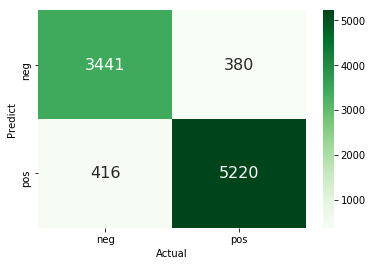

In [8]:
LABELS = {0:'neg',1:'pos'}

df = pd.DataFrame(data={'Predict':pred,
                       'Actual': y_val})
df_cm = df.groupby(['Predict','Actual']).count().reset_index()
df_cm['Predict'] = df_cm['Predict'].map(LABELS)
df_cm['Actual'] = df_cm['Actual'].map(LABELS)
count = df.groupby(['Predict','Actual'])['Predict'].count().values
df_cm['count'] = pd.Series(count)
df_cm = df_cm.pivot(index='Predict', columns='Actual', values='count')
sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap='Greens', xticklabels=True, yticklabels=True);

### Attention Based LSTM

In [37]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBED_DIM = 40
TIME_STEPS = MAXLEN
LSTM_UNITS = 60

def attention_lstm(inputs):
    input_dim = int(inputs.shape[2])
    att = Permute((2,1))(inputs)
    att = Dense(TIME_STEPS, activation='softmax', name='attention_vec')(att)
    att = Permute((2,1))(att)
    att_out = multiply([att, inputs], name='attention_mul')
    return att_out

inputs = Input(shape=(TIME_STEPS,))
embedding = Embedding(VOCAB_SIZE, EMBED_DIM, name='embedding')(inputs)
lstm = LSTM(LSTM_UNITS, input_shape=(TIME_STEPS, EMBED_DIM,), activation='tanh', return_sequences=True, name='lstm')(embedding)
att_lstm = attention_lstm(lstm)
att_lstm = Flatten()(att_lstm)
output = Dense(1, activation='sigmoid', name='sigmoid')(att_lstm)
model = Model(input=[inputs], output=output)

print(model.summary())
print("Model's input and output shapes \n")
for layer in model.layers:
    print('Model layer {}-- input_shape: {}; output_shape: {}'.format(layer.name, layer.input_shape, layer.output_shape))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 40)       179440      input_17[0][0]                   
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 50, 60)       24240       embedding[0][0]                  
__________________________________________________________________________________________________
permute_7 (Permute)             (None, 60, 50)       0           lstm[0][0]                       
__________________________________________________________________________________________________
attention_

c:\users\risson.yao\appdata\local\continuum\anaconda3\envs\learnnlp\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("si...)`


In [40]:
if tf.test.is_gpu_available==True:
    BATCH_SIZE = 96
    EPOCHS = 15
else:
    BATCH_SIZE = 64
    EPOCHS = 8

earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
checkpoint = ModelCheckpoint('model/attention_lstm1.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    
model.compile('adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(np.array(x_train), np.array(y_train),
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.1,
          shuffle=True,
          callbacks=[earlystopping, checkpoint])

Train on 161713 samples, validate on 17969 samples
Epoch 1/8
161713/161713 [==============================] - 206s 1ms/step - loss: 0.3289 - acc: 0.8601 - val_loss: 0.2942 - val_acc: 0.8806

Epoch 00001: val_loss improved from inf to 0.29418, saving model to model/attention_lstm1.h5
Epoch 2/8
161713/161713 [==============================] - 209s 1ms/step - loss: 0.2529 - acc: 0.8988 - val_loss: 0.2510 - val_acc: 0.8978

Epoch 00002: val_loss improved from 0.29418 to 0.25103, saving model to model/attention_lstm1.h5
Epoch 3/8
161713/161713 [==============================] - 215s 1ms/step - loss: 0.2250 - acc: 0.9118 - val_loss: 0.2368 - val_acc: 0.9047

Epoch 00003: val_loss improved from 0.25103 to 0.23682, saving model to model/attention_lstm1.h5
Epoch 4/8
161713/161713 [==============================] - 224s 1ms/step - loss: 0.2090 - acc: 0.9190 - val_loss: 0.2340 - val_acc: 0.9058

Epoch 00004: val_loss improved from 0.23682 to 0.23400, saving model to model/attention_lstm1.h5
Epoch

In [41]:
model = load_model('model/attention_lstm1.h5')

pred = model.predict(np.array(x_val))
pred = [1 if x[0]>.5 else 0 for x in pred]
report = classification_report(y_true=np.array(y_val), y_pred=pred, target_names=['neg','pos'])
print(report)

f1_macro = f1_score(y_val, pred, average='macro')
print('F1 score (macro): {}'.format(f1_macro))

             precision    recall  f1-score   support

        neg       0.90      0.90      0.90      3857
        pos       0.93      0.93      0.93      5600

avg / total       0.92      0.92      0.92      9457

F1 score (macro): 0.9132016636287716


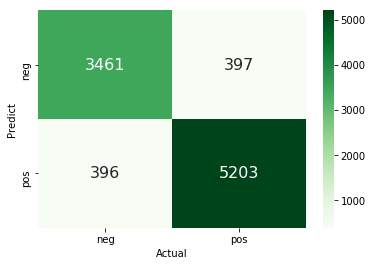

In [42]:
LABELS = {0:'neg',1:'pos'}

df = pd.DataFrame(data={'Predict':pred,
                       'Actual': y_val})
df_cm = df.groupby(['Predict','Actual']).count().reset_index()
df_cm['Predict'] = df_cm['Predict'].map(LABELS)
df_cm['Actual'] = df_cm['Actual'].map(LABELS)
count = df.groupby(['Predict','Actual'])['Predict'].count().values
df_cm['count'] = pd.Series(count)
df_cm = df_cm.pivot(index='Predict', columns='Actual', values='count')
sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap='Greens', xticklabels=True, yticklabels=True);

### Test

In [43]:
Xlive = []
ylive = []
with open('data/test2.txt','r',encoding='utf-8') as fo:
    for line in fo:
        row = line.split('\t',1)
        Xlive.append(row[1].strip())
        ylive.append(row[0])

Xlive[:5]

['质量好 大品牌', '服务态度友好 热情', '品牌好 车辆性能高', '车好', '物有所值']

In [44]:
best_model = model
Xlive_seq = tokenizer.texts_to_sequences(Xlive)
Xlive_seq = pad_sequences(Xlive_seq, maxlen=MAXLEN, padding='post', value=0)
pred_live = best_model.predict(Xlive_seq)
pred_live = [1 if pred[0] >.1 else 0 for pred in pred_live]

In [45]:
ylive = [int(x) for x in ylive]
report = classification_report(y_pred=np.array(pred_live), y_true=np.array(ylive), target_names=list(LABELS.values()))
print('Classification report: \n')
print(report)
f1_macro = f1_score(ylive, pred_live, average='macro')
print('F1 score (macro): {}'.format(f1_macro))

Classification report: 

             precision    recall  f1-score   support

        neg       0.66      0.78      0.72       207
        pos       1.00      0.99      1.00     16075

avg / total       0.99      0.99      0.99     16282

F1 score (macro): 0.857224381502597


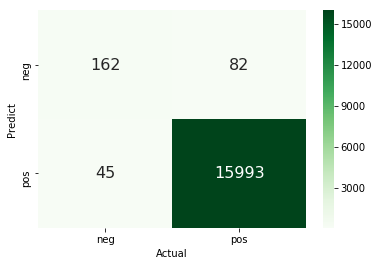

In [46]:
df = pd.DataFrame(data={'Predict':pred_live,
                       'Actual': ylive})
df_cm = df.groupby(['Predict','Actual']).count().reset_index()
df_cm['Predict'] = df_cm['Predict'].map(LABELS)
df_cm['Actual'] = df_cm['Actual'].map(LABELS)
count = df.groupby(['Predict','Actual'])['Predict'].count().values
df_cm['count'] = pd.Series(count)
df_cm = df_cm.pivot(index='Predict', columns='Actual', values='count')
sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g', cmap='Greens', xticklabels=True, yticklabels=True);

In [15]:
df = pd.DataFrame(data={'Predict':pred_live,
                       'Actual': ylive})
error_index = df[df['Predict']!=df['Actual']].index

text = [Xlive[i] for i in error_index]
actual = ['neg' if ylive[i]==0 else 'pos' for i in error_index]
predict = ['neg' if pred_live[i]==0 else 'pos' for i in error_index]

error_df = pd.DataFrame(data={'comment':text, 'actual':actual, 'predict':predict})
error_df

,comment,actual,predict
0,后备箱大 小毛病多,pos,neg
1,手工精致间隙小,pos,neg
2,燃油消耗量小,pos,neg
3,声誉高 ENTER 性价比高 ENTER 配件易找,pos,neg
4,产品信誉高,pos,neg
5,使用感一般 买了之后发现同价位还有更多性价比高的,pos,neg
6,后座距离小一点 其他都好的,pos,neg
7,车辆性价比高 但内饰做工不够好,pos,neg
8,相信核心部件,pos,neg
9,汽车质量问题没有解决,pos,neg
